# Neural Ordinary Differential Equations

如果我们想建立一个连续时间或连续深度的模型，微分方程求解器是一个有用的工具。但是我们究竟如何将odeint视为构建深度模型的层？计算它的梯度是可行的，但是数学推导比较多（implicit-functions-AD.ipynb翻译了一点），所以唯一缺少的是给它一些参数。本章将展示如何以及为什么这样做。

在本章中，我们不会使用任何深度学习框架。相反，我们将使用可通过 JAX 获得的可微分 Numpy 命令从头开始构建所有内容。

## 预备知识：训练残差网络

作为热身，我们可以只用几行代码定义一个简单的深度神经网络：

In [1]:
import jax.numpy as jnp

def mlp(params, inputs):
    # A multi-layer perceptron, i.e. a fully-connected neural network.
    for w, b in params:
        outputs = jnp.dot(inputs, w) + b  # Linear transform
        inputs = jnp.tanh(outputs)        # Nonlinearity
    return outputs

mlp只是线性和非线性层的组合。它的参数params是权重矩阵和偏置向量的列表。

为了制作更大的模型，我们可以链接或组合层在一起。作为一个标准示例，将一些较小的神经网络（例如mlp层）链接在一起，将每个输入添加到其输出中，称为残差网络：

In [2]:
def resnet(params, inputs, depth):
    for i in range(depth):
        outputs = mlp(params, inputs) + inputs
    return outputs

为了让这个模型拟合数据，我们还需要一个损失、一个初始化器和一个优化器：

In [3]:
import numpy.random as npr
from jax.api import jit, grad

resnet_depth = 3
def resnet_squared_loss(params, inputs, targets):
    preds = resnet(params, inputs, resnet_depth)
    return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

# A simple gradient-descent optimizer.
@jit
def resnet_update(params, inputs, targets):
    grads = grad(resnet_squared_loss)(params, inputs, targets)
    return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

作为健全性检查，让我们将我们的 resnet 拟合到一个示例1D 数据集（绿色圆圈）并绘制训练的模型的预测（蓝色曲线）：

Text(0, 0.5, 'output')

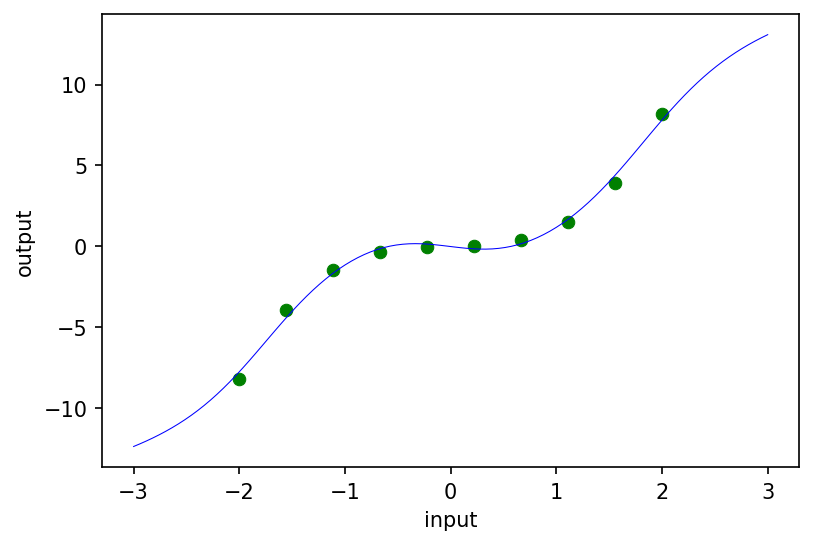

In [4]:
# Toy 1D dataset.
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

# Hyperparameters.
layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# Initialize and train.
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
    resnet_params = resnet_update(resnet_params, inputs, targets)

# Plot results.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')

## Building a neural ODE

与残差网络类似，神经 ODE（或 ODE-Net）将一个简单的层作为构建块，并将它的许多副本链接在一起以构建更大的模型。特别是，我们的“基础层”将指定 ODE 的动态，我们将根据 ODE 求解器上的逻辑将这些基础层的输出链接在一起。

### Specifying the dynamics layer

我们需要什么样的层来指定 ODE 的动态？回想一下，一个 ODE 初值问题具有以下形式：

$\dot y(t) = f(y(t), t,  \theta), \qquad y(0) = y_0,$

其中初始值 $y_0 \in \mathbb{R}^n$

我们添加了参数 θ 到动态中，所以动态函数有维度 $f : \mathbb{R}^{n} \times \mathbb{R} \times \mathbb{R}^{|\theta|} \to \mathbb{R}^n$，其中，| θ | 是我们添加到f的参数数量.

简单来说，我们需要动态函数来获取 ODE的当前状态 y(t)，当前时间 t, 和一些参数 θ，以及输出 $\frac{\partial y(t)}{\partial t}$，其形状与 y(t)一样.

我们可以通过简单地连接状态和当前时间并将其作为输入发送到mlp 来轻松构建这样的函数：

In [5]:
def nn_dynamics(state, time, params):
    state_and_time = jnp.hstack([state, jnp.array(time)])
    return mlp(params, state_and_time)

我们需要指定的模型的其余部分是如何组合这个动态层的评估。我们可以使用任何求解器。JAX 的odeint函数实现了标准的自适应步 Dormand-Price 求解器。

In [ ]:
from jax.experimental.ode import odeint

def odenet(params, input):
    start_and_end_times = jnp.array([0.0, 1.0])
    init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
    return final_state

不失一般性，我们可以使积分时间从 0 到 1。

就是这样！我们已经定义了一个 ODE 网络。下面，我们将详细讨论内发生的事情odeint，但现在，让我们将其连接到优化器，看看是否可以将其适合数据！

### Batching an ODE Net

为了支持批处理（在多个训练示例上评估 ODE-Net），我们可以简单地使用 Jax 的vmap函数，它会自动添加批处理维度。这种转换非常重要，因为odeint包含 while 循环和控制流，但 JAX 可以自动完成。vmapped odeint 创建在每个批处理元素上并行运行的独立并行求解器，在将所有最终状态一起返回之前等待最后一个完成。但它仍然将对动态函数的调用组合成一个在所有批处理元素之间共享的高效矢量化调用。

在没有 的环境中vmap，通常所做的是创建一个巨大的 ODE，该 ODE 结合了批处理中每个示例的动态，在对 的一次调用中解决所有问题odeint，然后在批处理中拆分结果。

In [ ]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

剩下的就是初始化参数，将模型连接到损失函数，并训练 ODE-Net：

In [ ]:
# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Initialize and train ODE-Net.
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet predictions', 'ODE Net predictions'))

这两种回归方法都匹配数据，但外推略有不同。

### Activation trajectories

在深度残差网络中，我们可以检查每个块之间的激活。在ODE-Net中，我们可以改为检查激活轨迹与深度的关系：

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()

@jit
def odenet_times(params, input, times):
    def dynamics_func(state, time, params):
        return mlp(params, jnp.hstack([state, jnp.array(time)]))
    return odeint(dynamics_func, input, times, params)

times = jnp.linspace(0.0, 1.0, 200)

for i in fine_inputs:
    ax.plot(odenet_times(odenet_params, i, times), times, lw=0.5)

ax.set_xlabel('input / output')
ax.set_ylabel('time / depth')


在这个只有一个隐藏单元的玩具环境中，轨迹永远不会相互交叉，从而限制了可以学习的功能类别。但是，可以通过向网络输入添加在网络输出处丢弃的辅助尺寸来克服此限制（如果需要）。

动态可以采取什么形式？
有一些限制可以使 ODE 解决方案定义明确且独一无二，我们将在后面讨论这些限制。但总的来说，它几乎可以是任何易处理的、可微的、参数化的函数。换句话说，odeint是需要另一层来指定其动力学功能的层。这一层可以是一个全连接网络、一个卷积网络、一个 U-net，甚至是某种类型的 Transformer！

我们可以在哪里使用odeint图层？
简短的回答是：任何可以使用残差网络的地方，都可以使用 ODENet。两者都要求输入的大小与输出的大小相同。

神经 ODE 的计算优势
为什么我们要将所有这些额外的复杂性引入我们的网络架构？与深度均衡模型一样，隐式定义模型的输出并将其留给自适应求解器来近似它有一些计算优势：

节省内存
有时，内存是训练非常大的神经网络的限制因素。具体来说，内存使用通常由在整个神经网络中存储中间隐藏单元激活来主导，这是计算训练梯度所必需的。

有两种主要方法可以解决这个问题。首先，检查点意味着仅在某些层存储激活，并根据需要重新计算下游层。其次，可逆架构约束神经网络，以便可以从较晚层的激活重建较早层的激活。缺点是这通常需要以某种主要方式限制层架构，例如一次只更新一半的单元。

对于训练基于 ODE 的模型，我们还有另一种选择。精确的ODE解决方案的一个不错的特性是，它们始终是完全可逆的！原则上，如果您知道任何时间的状态，您总是可以从那里重建 ODE 向前和向后的整个轨迹。在时间上向后运行 ODE 等效于在时间上向前运行相同的 ODE，但动力学由是˙= - f( − t , y). 这意味着 ODE 网络原则上可以在评估次数为 的内存成本不变的情况下进行训练f，而标准 resnet 的内存成本将线性增长。

在实践中，这只有在 ODE 在任一方向上都不太难求解时才可行，在这种情况下，前向和反向路径可能不匹配，或者可能过于昂贵而无法近似足够精细。然而，如果发生这种情况，人们通常可以通过检查初始状态和最终状态是否匹配来检测它，如果匹配，只需以额外的时间为代价进行一些检查点。也许令人惊讶的是，在由神经网络参数化的大型系统上，反向重构轨迹通常看起来足以在实践中进行训练。

自适应计算
我们希望我们的模型明智地使用它们的计算资源，并且只认真思考那些答案很重要的难题。在过去 120 年左右的时间里开发的自适应 ODE 求解器以有限的方式实现了这一点。

构建自适应 ODE 求解器的标准方法是监控由两种不同外推方法得出的预测轨迹的差异。如果这种差异变大，则表明至少有一种外推方法做出了错误的预测。然后，这些方法尝试通过重新开始并提前做出预测（即随着时间的推移采取更小的步骤）来恢复。

不同的求解器或多或少可以轻松地处理不同类型的动力学，但一般来说，动力学越简单，自适应求解器将答案逼近给定精度所需的步骤就越少。

能够在训练和测试时间权衡速度和精度。
大多数自适应 ODE 求解器要求用户指定求解器将尝试满足的误差容限（相对和绝对）。对于大多数真实系统，我们不能保证会满足任何特定的错误目标。但即使在这种情况下，容错也是一种在计算时间与答案精度之间进行权衡的方法。在某些方面，这是一种比权重修剪或量化更灵活的方法，因为可以在整个训练过程中甚至在部署模型之后调整容差。

神经 ODE 的建模优势
除了与固定深度网络具有不同的计算权衡之外，基于 ODE 的网络的精确解也是与标准神经网络不同的模型类，具有一些不同的属性：

易处理的变量变化
有时在物理学中，采用离散过程的连续时间限制可以简化结果计算。这恰好适用于归一化流模型，该模型通过简单基础密度的一系列离散可逆变换来构建复杂的密度。该FFJORD模型使用这种方法。

连续时间时间序列模型。
有大量关于拟合连续时间序列模型的文献，它们对于处理不规则采样的时间序列数据特别有用。 这是一个评论。基于 ODE 的模型可以自然地处理此类数据。

学习平滑同胚
在我们确实想要参数化同胚的情况下，例如在参数化非自相交形状时，连续时间归一化流会自动强制执行此约束。例如，PointNet使用这种方法将 3D 表面拟合到数据。

神经 ODE 的建模缺点
对激活函数的限制。
如果 ODE 解的动力学不是连续可微和 Lipshitz，则不一定是唯一定义的。大多数标准非线性如relu和都满足这些条件tanh。[注意：我在教程中误解了这一点]。第二个条件意味着我们不能使用某些类型的注意力，因此在使用基于转换器的动态时需要格外小心。

只能学习平滑同胚。
在我们不想学习同胚的情况下，我们可能需要用额外的维度来增加我们的状态，以恢复标准神经网络所享有的相同类型的普遍性。 本文使这些主张更加精确。

确定性动力学。
使用 ODE 构建时间序列模型的一个问题是它们假设动态是确定性的。因此，必须将状态的任何未知或随机变化单独添加到模型中。随机微分方程给出了一类主要的随机连续时间动力学，也可以通过梯度下降拟合。

神经ODE的计算缺点
速度。
这是不使用神经 ODE 的主要原因。具体来说，在相同任务上，ODE 网络通常需要比固定架构更多的内层评估。更糟糕的是，在训练期间，正在学习的动态往往变得越来越难以解决。如果我们认为网络是“学习深入”并表示更复杂的功能，那么这是有道理的。但是，我们希望在预测性能与计算成本之间取得平衡，因此我们需要以某种方式鼓励我们的模型向东求解。最近有一些关于正则化 ODE 更容易解决的工作：

学习容易求解的微分方程
如何训练您的神经 ODE：雅可比矩阵和动力学正则化的世界
额外的超参数。
在标准网络中，我们必须选择网络的深度作为超参数。在 ODE Nets 中，我们需要指定求解器的容错性以及求解器策略。

软件
以下是一些更全面的工具包，可以让您适应神经 ODES：

TorchDiffEq-一个PyTorch库，用于构建和拟合神经ODE模型。
Jax - Python 的通用数值计算框架，其中包括可微分的 Dopri5 求解器。
JuliaDiffEq - 一套全面的 Julia 语言微分方程求解器。
TorchDyn-一组模型模板，教程和应用程序笔记本。
随机和偏微分方程
除了常微分方程之外，还有许多其他可以通过梯度拟合的微分方程变体，基于微分方程开发新的模型类是一个活跃的研究领域。几乎任何类型的微分方程的解都可以看成是一层！

以下是对这些领域最近工作的一些提示：

ICLR 深度神经模型与微分方程集成研讨会
随机微分方程的可缩放梯度
学习可组合的能源替代物以减少PDE订单
用于快速 PDE 约束优化的摊销有限元分析